# Проект. Предсказание коэффициента восстановления золота из золотосодержащей руды.

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

#### Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

#### Нужно спрогнозировать сразу две величины:  
1. эффективность обогащения чернового концентрата `rougher.output.recovery`
2. эффективность обогащения финального концентрата `final.output.recovery`

#### Описание данных:  
`floatbank` - флотационная установка 
`ag, pb, sol, au` - Серебро, Свинц, Соль, Золото  

Этап Флотации - Rougher  
`rougher.input.feed_ag(pb, sol, au)` - концентрация исходного сырье ag, pb, sol, au  
`rougher.input.feed_rate` - скорость подачи сырья  
`rougher.input.feed_size` - размер гранул сырья  
`rougher.input.floatbank_10_sulfate(xanthate)` - подача флотационных реагентов sulfate, xanthate  
`rougher.output.concentrate_ag(pb, sol, au)` - концентрация на выходе ag, pb, sol, au  
`rougher.output.tail_ag` - отвальные хвосты ag, pb, sol, au после флотации  
`rougher.output.recovery` - Эффективность обогащения после флотации  
`rougher.state.floatbank10_a_air(level)` - параметры объема воздуха и уровня жидкости, характеризующие текущее состояние этапа  
`rougher.calculation` - расчётные характеристики  

Этап Первичной очистки - Primary_cleaner  
`primary_cleaner.input.sulfate(depressant, xanthate)` - подача реагентов sulfate, depressant, xanthate  
`primary_cleaner.input.feed_size` - размер гранул сырья на входе  
`primary_cleaner.output.concentrate_ag(pb, sol, au)` - концентрация на выходе ag, pb, sol, au  
`primary_cleaner.output.tail_ag(pb, sol, au)` - отвальные хвосты ag, pb, sol, au после первичной очистки  
`primary_cleaner.state.floatbank8_a_air(level)` - параметры объема воздуха и уровня жидкости, характеризующие текущее состояние этапа  

Этап Вторичной очистки - Secondary_cleaner  
`secondary_cleaner.output.tail_ag` - отвальные хвосты ag, pb, sol, au после вторичной очистки  
`secondary_cleaner.state.floatbank2_a_air(level)` - параметры объема воздуха и уровня жидкости, характеризующие текущее состояние этапа  

Финальный концентрат - Final  
`final.output.recovery` - Эффективность обогащения финального концентрата  
`final.output.concentrate_ag(pb, sol, au)` - финальный концентрат ag, pb, sol, au  
`final.output.tail_ag(pb, sol, au)` - финальные отвальные хвосты ag, pb, sol, au  

## Глава 1. Загрузка и подготовка данных

In [1]:
!pip install -U scikit-learn --user

Вызовем библиотеки для реализации проекта:

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from sklearn.dummy import DummyRegressor

Напишем функции first_view для ознакомления с каждой из таблиц и вызовем ее для каждой

In [3]:
def first_view(df):
    print(df.info()) 
    return df.head(10)

Прочитаем файлы, создадим ДатаФреймы, через функцию выведем информацию и первые 10 строк таблиц

In [4]:
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')
first_view(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
first_view(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
first_view(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Выведем столбцы, которых нет в тестовой выборке:

In [7]:
set(df_full.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Проанализируем типы отстутствующих признаков:
1. Это расчетные, получаемые из других данных(например `rougher.calculation` и `final.output.recovery`)
2. Измеряемые, получаемые в процессе обработки(например `final.output.concentrate_au` и `rougher.output.tail_sol`)

Эти данные отсутствуют на момент прогноза, т.к. замеряются и/или рассчитываются значительно позже, это тип `output`— параметры продукта в признаках.
Также в ДатаФрейме `df_test` отсутствуют целевые признаки `rougher.output.recovery`и `final.output.recovery`.  
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей.

Проверим, что эффективность обогащения рассчитана правильно. Напишем для этого функцию `recovery(C, F, T)`, в которой:  
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [8]:
def recovery(C, F, T):
    return C * (F - T) / (F * (C - T)) * 100                          

Вычислите её на обучающей выборке для признака rougher.output.recovery.  
Найдем MAE между нашими расчётами и значением признака.

In [9]:
df_train['counted_recovery'] = recovery(df_train['rougher.output.concentrate_au'], df_train['rougher.input.feed_au'],
                                        df_train['rougher.output.tail_au'])
df_train['counted_recovery'].describe()

count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
Name: counted_recovery, dtype: float64

Из за того, что в числителе и знаменателе могут оказаться 0, функция возвратила для некоторых значений -inf и inf.  
Для того чтобы посчитать среднее абсолютное отклонение MAE, удалим NaN'ы.

In [10]:
df_train_for_mae = df_train[['rougher.output.recovery','counted_recovery']].dropna()

In [11]:
def mae(recovery, counted_recovery):
    mae = 1 / len(recovery) * (abs(recovery - counted_recovery)).sum() 
    return mae

mae(df_train_for_mae['rougher.output.recovery'], df_train_for_mae['counted_recovery'])

9.444891926100695e-15

Значение метрики в порядке e-15 это говорит о том, что расчитанные данные и данные в таблице по recovery равны и рассчитаны верно.

Вернем исходный обучающий ДатаФрейм:

In [12]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')

Выведем количество пропусков по всем ДатаФреймам:

In [13]:
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [14]:
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [15]:
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Из условия известно, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.  
Воспользуемся `KNNImputer` из `sklearn.impute`, заполняющий пропуски средним от указанных соседних значений:

In [16]:
imputer = KNNImputer(n_neighbors=2)
df_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level'] = (
    imputer.fit_transform(df_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level']))

In [17]:
df_train.isna().sum().sum()

0

Приведем столбец `date` к формату даты и используем его в качестве индексов:

In [18]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_train = df_train.set_index(['date'])

Тоже самое сделаем для `df_test` и `df_full`

In [19]:
imputer = KNNImputer(n_neighbors=2)
df_test.loc[:, df_test.columns != 'date' ] = imputer.fit_transform(df_test.loc[:, df_test.columns != 'date' ])

In [20]:
df_test.isna().sum().sum()

0

In [21]:
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_test = df_test.set_index(['date'])

In [22]:
imputer = KNNImputer(n_neighbors=2)
df_full.loc[:, df_full.columns != 'date' ] = imputer.fit_transform(df_full.loc[:, df_full.columns != 'date' ])

In [23]:
df_full.isna().sum().sum()

0

In [24]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_full = df_full.set_index(['date'])

Для того чтобы восстановить недостающие значения `rougher.output.recovery`и `final.output.recovery` создадим ДатаФрейм по индексам `df_test`

In [25]:
df_test_full = pd.DataFrame(data=df_full, index=df_test.index)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           5856 non-null float64
final.output.concentrate_pb                           5856 non-null float64
final.output.concentrate_sol                          5856 non-null float64
final.output.concentrate_au                           5856 non-null float64
final.output.recovery                                 5856 non-null float64
final.output.tail_ag                                  5856 non-null float64
final.output.tail_pb                                  5856 non-null float64
final.output.tail_sol                                 5856 non-null float64
final.output.tail_au                                  5856 non-null float64
primary_cleaner.input.sulfate                         5856 non-null float64
primary_cleaner.input.depressant                      5856 non-null float64
primary_cleaner.input

### Выводы по главе 1:

> - Данные предобработаны для дальнейшего анализа и построения моделей.  
- эффективность обогащения рассчитана правильно. MAE между нашими расчётами и значением признака одинаковы. Т.е. смело можно использовать данные из таблицы
- Проанализированы признаки, недоступные в тестовой выборке. Эти данные отсутствуют на момент прогноза, т.к. замеряются и/или рассчитываются значительно позже `output` — параметры продукта


## Глава 2. Анализ данных

Напишем функции: 
- **boxplot_values** - возвращает значения диаграммы размаха
- **mean_var_std** - возвращает среднее, дисперсию, стандартное отклонение и доверительный интервал [-2σ: +2σ]
- **plot_and_box** - строит распределение, диаграмму размаха и график плотности распределения
- **plots_and_values** - запускает все вышеперечисленные функции

In [26]:
def boxplot_values(df, column):
    upper_quartile = df[column].quantile(.75)
    lower_quartile = df[column].quantile(.25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = df[column][df[column] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = df[column][df[column] >= lower_quartile - 1.5 * iqr].min()
    median = df[column].median()
    print ('Нижний квартиль: {:.1f}'.format(lower_quartile), '\n' 
           'Верхний квартиль: {:.1f}'.format(upper_quartile), '\n'
           'Нижний "ус": {:.1f}'.format(lower_whisker), '\n'
           'Верхний "ус": {:.1f}'.format(upper_whisker), '\n'
           'Медиана: {:.1f}'.format(median)
          )

In [27]:
def mean_var_std(df, column):
    mean = np.mean(df[column])
    variance = np.var(df[column], ddof=1)
    standard_deviation = np.std(df[column], ddof=1)
    bottom_line = mean - standard_deviation * 2
    top_line= mean + standard_deviation * 2
    print ('Среднее: {:.1f}'.format(mean), '\n' 
           'Дисперсия: {:.1f}'.format(variance), '\n'
           'Стандартное отклонение: {:.1f}, интервал 95% [-2σ: +2σ]: {:.1f} - {:.1f}'.format(standard_deviation, bottom_line, top_line)
          )

In [28]:
def plot_and_box(df, column):
    fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(17,7))
    ax.yaxis.tick_right()

    (df[column].plot(y=column, style='o', c='g', grid= True, legend=False, ax=ax)
                             .set(xlabel='Дата измерений', ylabel='Значение'))
    df.boxplot(column=column, ax=ax2).set(xlabel='Диаграмма размаха')
    sns.distplot(df[column], ax=ax3, vertical=True).set(xlabel='Плотность частоты');

In [29]:
def plots_and_values(df, column):
    plot_and_box(df, column), boxplot_values(df, column), mean_var_std(df, column)

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.  
Сделаем срез по металлам на каждом этапе.

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 16860 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                                  16860 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant                      16860 non-null float64
primary_c

In [31]:
df_concentrate = df_train[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au',
                           'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                           'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
                           'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
df_concentrate.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
date,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,11.500771,8.547551,6.055403,7.101074,10.389648,9.889648,19.793808,34.174427,42.192020
2016-01-15 01:00:00,6.161113,2.266033,6.478583,11.615865,8.558743,6.029369,7.278807,10.497069,9.968944,20.050975,34.118526,42.701629
2016-01-15 02:00:00,6.116455,2.159622,6.362222,11.695753,8.603505,6.055926,7.216833,10.354494,10.213995,19.737170,33.969464,42.657501
2016-01-15 03:00:00,6.043309,2.037807,6.118189,11.915047,7.221879,6.047977,7.175616,8.496563,9.977019,19.320810,28.260743,42.689819
2016-01-15 04:00:00,6.060915,1.786875,5.663707,12.411054,9.089428,6.148599,7.240205,9.986786,10.142511,19.216101,33.044932,42.774141


Построим boxplot

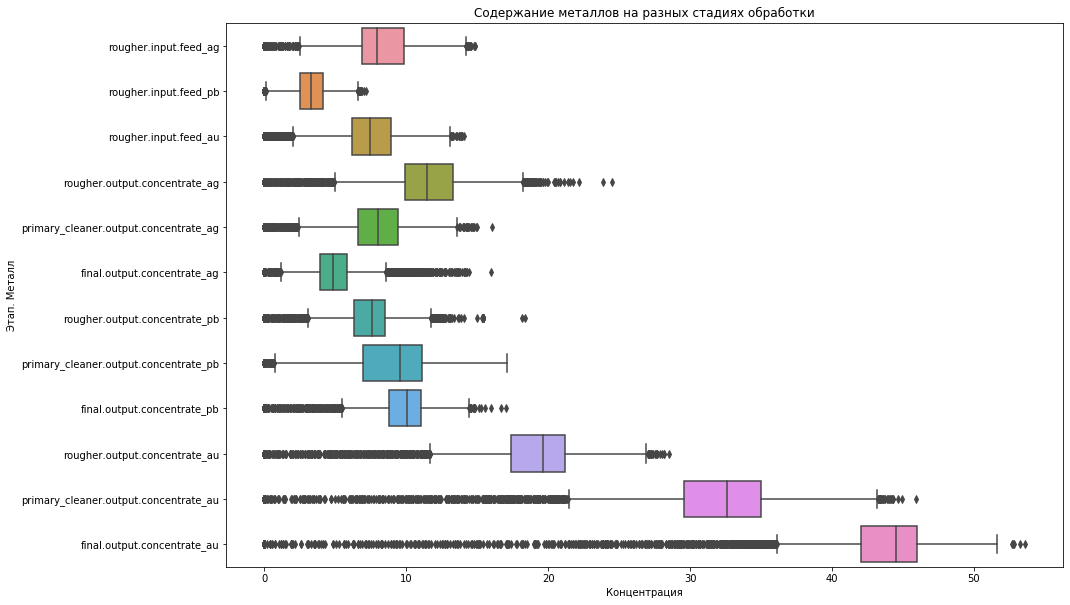

In [32]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_concentrate, orient='h').set(xlabel='Концентрация', ylabel='Этап. Металл', title='Содержание металлов на разных стадиях обработки');

Концентрация Au от этапа к этапу растет, что логично, в тоже время концентрация серебра падает. Свинец практически не меняет свою концентрацию в сырье.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.  
Построим boxplot:

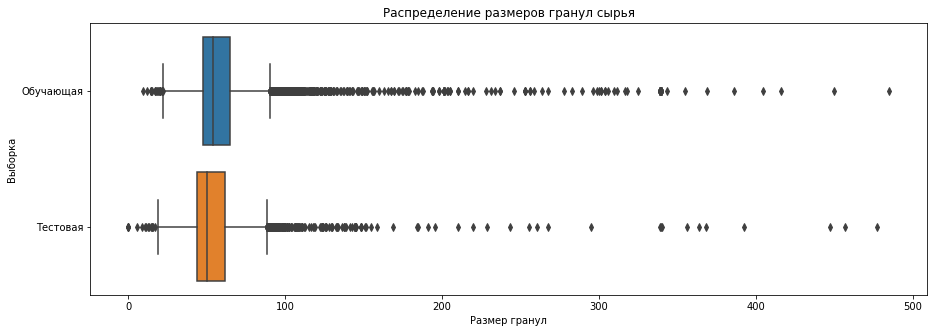

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(data=(df_train['rougher.input.feed_size'], 
                  df_test['rougher.input.feed_size']), orient='h').set(xlabel='Размер гранул', ylabel='Выборка', title='Распределение размеров гранул сырья')
plt.yticks([0,1], ['Обучающая', 'Тестовая']);

распределение, диаграмма размаха и график плотности распределения на обучающей выборке

Нижний квартиль: 47.6 
Верхний квартиль: 64.6 
Нижний "ус": 22.4 
Верхний "ус": 90.2 
Медиана: 54.2
Среднее: 58.6 
Дисперсия: 569.6 
Стандартное отклонение: 23.9, интервал 95% [-2σ: +2σ]: 10.9 - 106.3


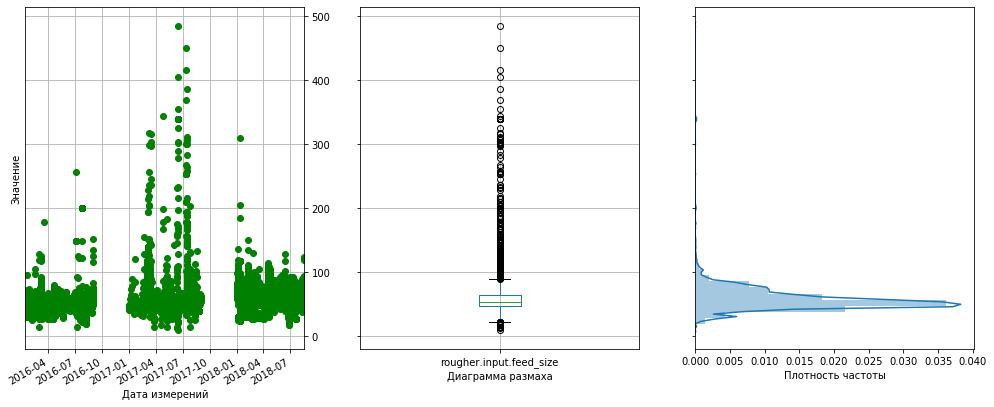

In [34]:
plots_and_values(df_train,'rougher.input.feed_size')

распределение, диаграмма размаха и график плотности распределения на тестовой выборке

Нижний квартиль: 43.9 
Верхний квартиль: 61.6 
Нижний "ус": 19.2 
Верхний "ус": 88.2 
Медиана: 50.0
Среднее: 55.9 
Дисперсия: 515.5 
Стандартное отклонение: 22.7, интервал 95% [-2σ: +2σ]: 10.5 - 101.3


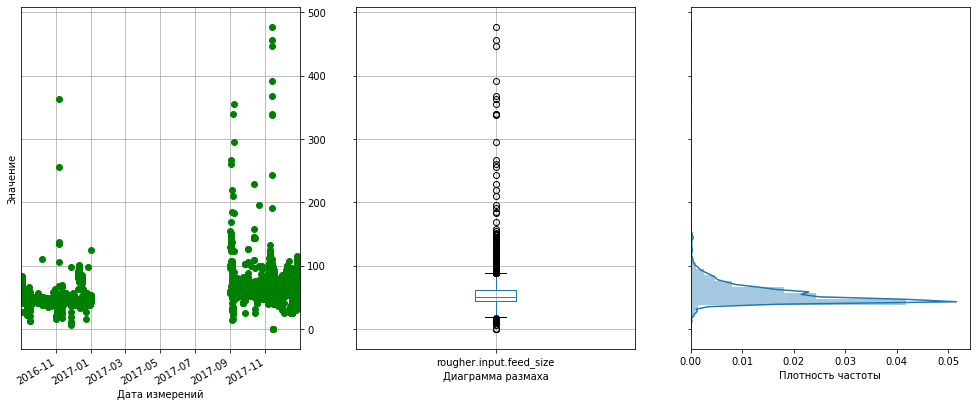

In [35]:
plots_and_values(df_test, 'rougher.input.feed_size')

Напишем функцию deviation_compare, представляющая плотности распределения для 2-х выборок на одном графике: 

In [36]:
def deviation_compare(df1, column1, df2, column2):
    plt.figure(figsize=(17,5))
    sns.distplot(df1[column1], color='g').set(xlabel='Среднее по значениям', ylabel='Плотность частоты', title='Распределение по размерам гранул сырья');
    sns.distplot(df2[column2], color='b').set(xlabel='Среднее по значениям', ylabel='Плотность частоты');

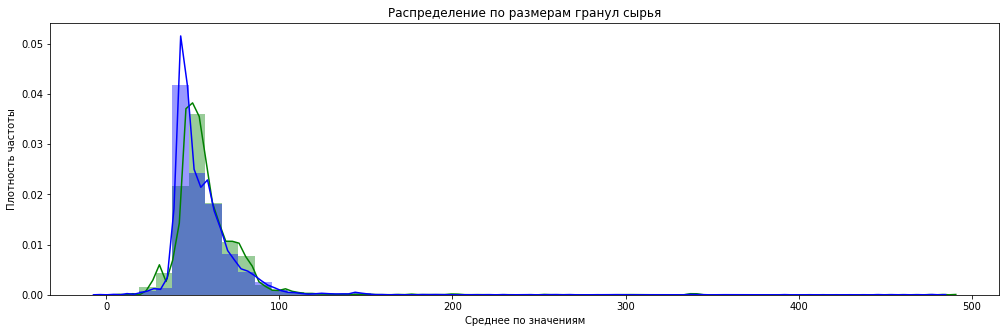

In [37]:
deviation_compare(df_train, 'rougher.input.feed_size', df_test, 'rougher.input.feed_size')

Все вышеперечисленные графики показывают, что размеры гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга, что не окажет существенного влияния на построение модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  
Создадим срез df_sum:

In [38]:
df_sum = df_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                   'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
                   'rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au',
                   'rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']]
df_sum

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_sol,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol
date,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,11.500771,8.547551,6.055403,2.284912,7.101074,10.389648,9.889648,6.486150,19.793808,34.174427,42.192020,36.808594,28.029297,19.529297,5.507324
2016-01-15 01:00:00,6.161113,11.615865,8.558743,6.029369,2.266033,7.278807,10.497069,9.968944,6.478583,20.050975,34.118526,42.701629,35.753385,28.067063,19.369147,5.257781
2016-01-15 02:00:00,6.116455,11.695753,8.603505,6.055926,2.159622,7.216833,10.354494,10.213995,6.362222,19.737170,33.969464,42.657501,35.971630,27.454037,19.167579,5.383759
2016-01-15 03:00:00,6.043309,11.915047,7.221879,6.047977,2.037807,7.175616,8.496563,9.977019,6.118189,19.320810,28.260743,42.689819,36.862241,27.341277,15.978538,4.858634
2016-01-15 04:00:00,6.060915,12.411054,9.089428,6.148599,1.786875,7.240205,9.986786,10.142511,5.663707,19.216101,33.044932,42.774141,34.347666,27.041023,19.199864,4.939416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,6.091855,11.124896,6.559174,3.224920,4.617558,10.984003,12.445966,11.356233,5.335862,18.603550,32.940215,46.713954,37.369774,30.068876,7.056338,6.803482
2018-08-18 07:59:59,6.121323,11.425983,6.612376,3.195978,4.144989,10.888213,12.623947,11.349355,4.838619,18.441436,32.925325,46.866780,38.591551,29.783972,7.542264,6.862249
2018-08-18 08:59:59,5.970515,8.523497,7.128896,3.109998,4.020002,8.955135,12.633558,11.434366,4.525061,15.111231,31.856742,46.795691,40.074026,22.786467,7.941900,6.886013


Концентрация в руде:

In [39]:
df_sum_input_feed = df_sum.iloc[:, 0::4]
df_sum_input_feed

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol
date,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,36.808594
2016-01-15 01:00:00,6.161113,2.266033,6.478583,35.753385
2016-01-15 02:00:00,6.116455,2.159622,6.362222,35.971630
2016-01-15 03:00:00,6.043309,2.037807,6.118189,36.862241
2016-01-15 04:00:00,6.060915,1.786875,5.663707,34.347666
...,...,...,...,...
2018-08-18 06:59:59,6.091855,4.617558,5.335862,37.369774
2018-08-18 07:59:59,6.121323,4.144989,4.838619,38.591551
2018-08-18 08:59:59,5.970515,4.020002,4.525061,40.074026


Добавим столбец с суммарной концентрацией:

In [40]:
df_sum_input_feed['sum'] = df_sum_input_feed.sum(axis=1)
df_sum_input_feed

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol,sum
date,,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,36.808594,51.680034
2016-01-15 01:00:00,6.161113,2.266033,6.478583,35.753385,50.659114
2016-01-15 02:00:00,6.116455,2.159622,6.362222,35.971630,50.609929
2016-01-15 03:00:00,6.043309,2.037807,6.118189,36.862241,51.061546
2016-01-15 04:00:00,6.060915,1.786875,5.663707,34.347666,47.859163
...,...,...,...,...,...
2018-08-18 06:59:59,6.091855,4.617558,5.335862,37.369774,53.415050
2018-08-18 07:59:59,6.121323,4.144989,4.838619,38.591551,53.696482
2018-08-18 08:59:59,5.970515,4.020002,4.525061,40.074026,54.589604


Тоже самое для чернового:

In [41]:
df_sum_rougher = df_sum.iloc[:, 1::4]
df_sum_rougher['sum'] = df_sum_rougher.sum(axis=1)
df_sum_rougher

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,rougher.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,11.500771,7.101074,19.793808,28.029297,66.424950
2016-01-15 01:00:00,11.615865,7.278807,20.050975,28.067063,67.012710
2016-01-15 02:00:00,11.695753,7.216833,19.737170,27.454037,66.103793
2016-01-15 03:00:00,11.915047,7.175616,19.320810,27.341277,65.752751
2016-01-15 04:00:00,12.411054,7.240205,19.216101,27.041023,65.908382
...,...,...,...,...,...
2018-08-18 06:59:59,11.124896,10.984003,18.603550,30.068876,70.781325
2018-08-18 07:59:59,11.425983,10.888213,18.441436,29.783972,70.539603
2018-08-18 08:59:59,8.523497,8.955135,15.111231,22.786467,55.376330


После первой очистки:

In [42]:
df_sum_primary_cleaner = df_sum.iloc[:, 2::4]
df_sum_primary_cleaner['sum'] = df_sum_primary_cleaner.sum(axis=1)
df_sum_primary_cleaner

,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,8.547551,10.389648,34.174427,19.529297,72.640924
2016-01-15 01:00:00,8.558743,10.497069,34.118526,19.369147,72.543485
2016-01-15 02:00:00,8.603505,10.354494,33.969464,19.167579,72.095042
2016-01-15 03:00:00,7.221879,8.496563,28.260743,15.978538,59.957723
2016-01-15 04:00:00,9.089428,9.986786,33.044932,19.199864,71.321010
...,...,...,...,...,...
2018-08-18 06:59:59,6.559174,12.445966,32.940215,7.056338,59.001692
2018-08-18 07:59:59,6.612376,12.623947,32.925325,7.542264,59.703912
2018-08-18 08:59:59,7.128896,12.633558,31.856742,7.941900,59.561096


Финальный концентрат:

In [43]:
df_sum_final = df_sum.iloc[:, 3::4]
df_sum_final['sum'] = df_sum_final.sum(axis=1)
df_sum_final

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,6.055403,9.889648,42.192020,5.507324,63.644396
2016-01-15 01:00:00,6.029369,9.968944,42.701629,5.257781,63.957723
2016-01-15 02:00:00,6.055926,10.213995,42.657501,5.383759,64.311180
2016-01-15 03:00:00,6.047977,9.977019,42.689819,4.858634,63.573449
2016-01-15 04:00:00,6.148599,10.142511,42.774141,4.939416,64.004667
...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,46.713954,6.803482,68.098589
2018-08-18 07:59:59,3.195978,11.349355,46.866780,6.862249,68.274362
2018-08-18 08:59:59,3.109998,11.434366,46.795691,6.886013,68.226068


Построим boxplot распределения по этапам обработки:

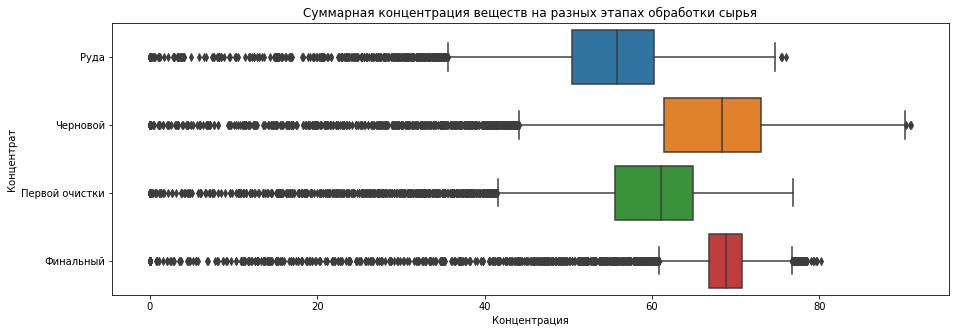

In [44]:
plt.figure(figsize=(15,5))
sns.boxplot(data=(df_sum_input_feed['sum'], 
                  df_sum_rougher['sum'], 
                  df_sum_primary_cleaner['sum'], 
                  df_sum_final['sum']), orient='h').set(xlabel='Концентрация', ylabel='Концентрат', title='Суммарная концентрация веществ на разных этапах обработки сырья')
plt.yticks([0,1,2,3], ['Руда', 'Черновой', 'Первой очистки', 'Финальный']);

Построим распределение, диаграмму размаха и график плотности распределения суммарной концентрации по этапам обработки

Нижний квартиль: 50.4 
Верхний квартиль: 60.3 
Нижний "ус": 35.7 
Верхний "ус": 74.7 
Медиана: 55.8
Среднее: 50.7 
Дисперсия: 318.5 
Стандартное отклонение: 17.8, интервал 95% [-2σ: +2σ]: 15.0 - 86.4


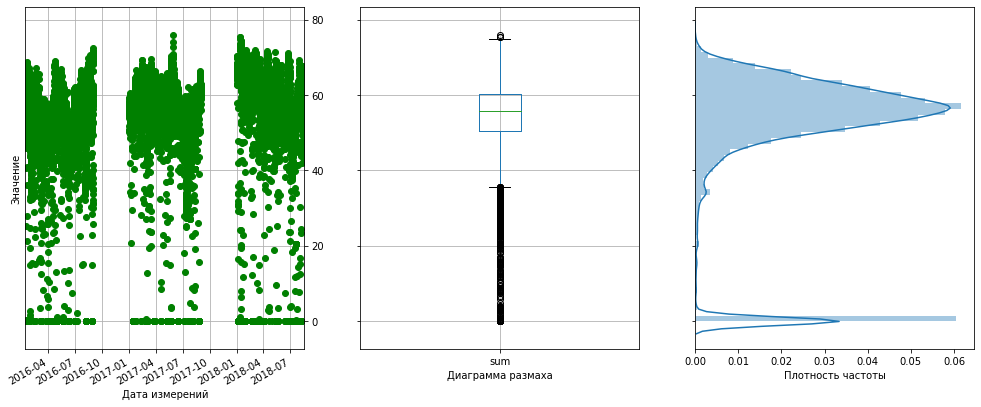

In [45]:
plots_and_values(df_sum_input_feed, 'sum')

Нижний квартиль: 61.5 
Верхний квартиль: 73.0 
Нижний "ус": 44.2 
Верхний "ус": 90.2 
Медиана: 68.3
Среднее: 60.1 
Дисперсия: 567.6 
Стандартное отклонение: 23.8, интервал 95% [-2σ: +2σ]: 12.4 - 107.7


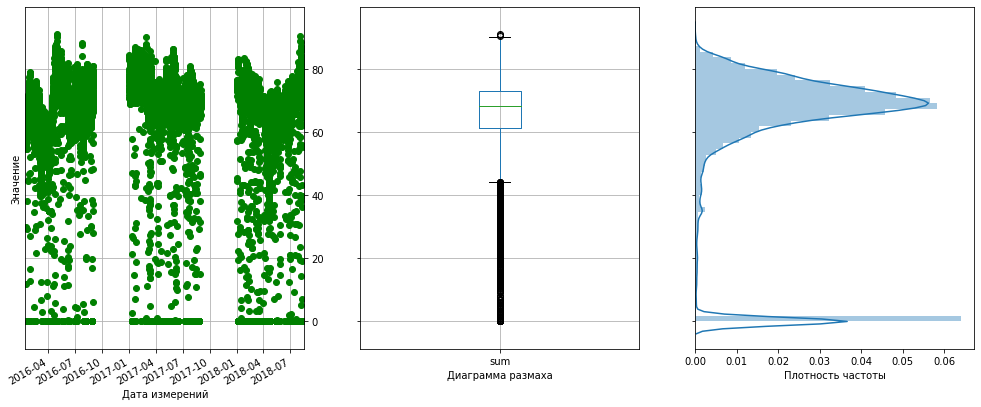

In [46]:
plots_and_values(df_sum_rougher, 'sum')

Нижний квартиль: 55.6 
Верхний квартиль: 64.9 
Нижний "ус": 41.6 
Верхний "ус": 76.9 
Медиана: 61.1
Среднее: 54.2 
Дисперсия: 412.4 
Стандартное отклонение: 20.3, интервал 95% [-2σ: +2σ]: 13.6 - 94.8


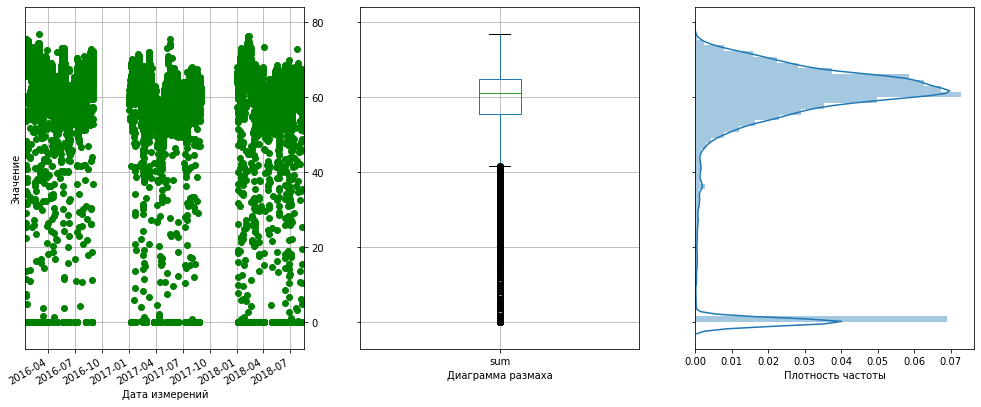

In [47]:
plots_and_values(df_sum_primary_cleaner, 'sum')

Нижний квартиль: 66.8 
Верхний квартиль: 70.8 
Нижний "ус": 60.8 
Верхний "ус": 76.7 
Медиана: 68.9
Среднее: 61.6 
Дисперсия: 460.6 
Стандартное отклонение: 21.5, интервал 95% [-2σ: +2σ]: 18.7 - 104.5


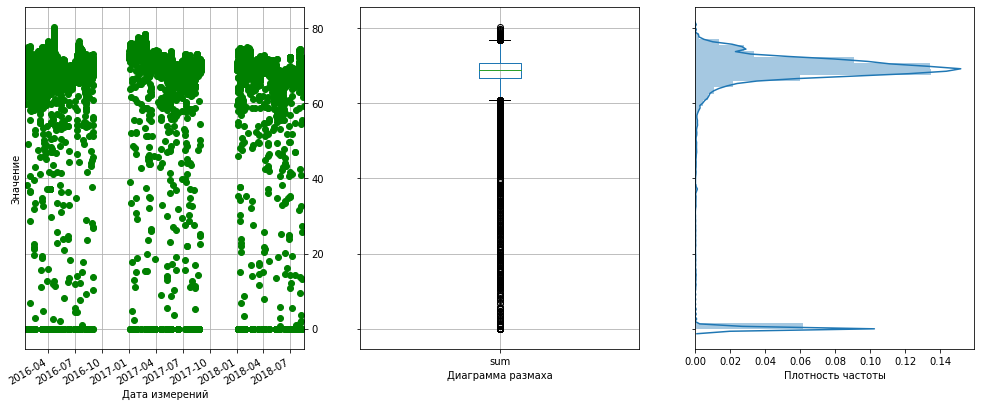

In [48]:
plots_and_values(df_sum_final, 'sum')

Как видим из графиков, на каждом этапе есть аномальные значения 0.

In [49]:
df_sum_input_feed[df_sum_input_feed['sum'] == 0]

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol,sum
date,,,,,
2016-01-19 03:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 04:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 05:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 06:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 07:00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2018-07-20 10:59:59,0.0,0.0,0.0,0.0,0.0
2018-07-20 11:59:59,0.0,0.0,0.0,0.0,0.0
2018-07-21 23:59:59,0.0,0.0,0.0,0.0,0.0


Так как нас интересует концентрация золота, сравним количество 0 в суммарной и концентрации золота на каждом этапе.

In [50]:
len(df_sum_input_feed[df_sum_input_feed['sum'] == 0]) == len(df_sum_input_feed[df_sum_input_feed['rougher.input.feed_au'] == 0])

True

In [51]:
len(df_sum_rougher[df_sum_rougher['sum'] == 0]) == len(df_sum_rougher[df_sum_rougher['rougher.output.concentrate_au'] == 0])

True

In [52]:
len(df_sum_primary_cleaner[df_sum_primary_cleaner['sum'] == 0]) == len(df_sum_primary_cleaner[df_sum_primary_cleaner['primary_cleaner.output.concentrate_au'] == 0])

True

In [53]:
len(df_sum_final[df_sum_final['sum'] == 0]) == len(df_sum_final[df_sum_final['final.output.concentrate_au'] == 0])

True

Удалим 0 и выведем обновленную обучающую выборку `df_train`

In [54]:
df_train= df_train[(df_train['rougher.input.feed_au'] !=0) & 
         (df_train['rougher.output.concentrate_au'] !=0) &
         (df_train['primary_cleaner.output.concentrate_au'] !=0) &
         (df_train['final.output.concentrate_au'] != 0)]
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Разметим обучающие признаки и целевые признаки `rougher.output.recovery` и `final.output.recovery`  
`df_test` содержит все признаки для обучения

In [55]:
test_columns =  set(df_test.columns)

In [56]:
df_train_features = df_train.loc[:, test_columns]
df_train_features
df_train_target = df_train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
df_train_target

,rougher.output.recovery,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016
...,...,...
2018-08-18 06:59:59,89.574376,73.755150
2018-08-18 07:59:59,87.724007,69.049291
2018-08-18 08:59:59,88.890579,67.002189


Разделим `features` на `rougher_features` и `final_features`  
Для фильтрации по `rougher` используем метод `.filter()`

In [57]:
df_train_rougher_features = df_train_features.filter(regex='^rougher',axis=1)
df_train_rougher_features.head()

,rougher.state.floatbank10_f_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_a_level,rougher.state.floatbank10_f_level,rougher.state.floatbank10_c_air,rougher.input.floatbank11_xanthate,rougher.input.feed_au,rougher.state.floatbank10_d_level,rougher.input.floatbank11_sulfate,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_pb,rougher.input.feed_size,rougher.state.floatbank10_a_air,rougher.input.floatbank10_sulfate,rougher.state.floatbank10_e_air,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_d_air,rougher.state.floatbank10_b_air,rougher.input.feed_ag,rougher.state.floatbank10_e_level,rougher.state.floatbank10_b_level
date,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,1416.354980,-442.204468,-404.066986,-451.939636,1602.375000,6.005818,6.486150,-451.294128,11.836743,36.808594,523.546326,2.284912,55.486599,999.706909,11.986616,1404.472046,6.007990,1598.937256,1603.011353,6.100378,-455.462982,-434.715027
2016-01-15 01:00:00,1399.719514,-449.830646,-400.065196,-450.119001,1600.479580,6.012594,6.478583,-449.953649,11.996163,35.753385,525.290581,2.266033,57.278666,1000.286398,11.971193,1399.227084,6.005766,1600.527589,1600.754587,6.161113,-450.869848,-449.953435
2016-01-15 02:00:00,1400.316682,-449.954491,-400.074028,-450.527147,1599.672797,6.204633,6.362222,-449.954185,11.920305,35.971630,530.026610,2.159622,57.510649,999.719565,11.920603,1399.180945,6.197377,1599.849325,1599.337330,6.116455,-449.937588,-450.008530
2016-01-15 03:00:00,1400.234743,-449.910497,-400.200179,-449.790835,1600.012842,6.196578,6.118189,-450.130127,11.692450,36.862241,542.590390,2.037807,57.792734,999.814770,11.630094,1400.943157,6.203177,1597.725177,1600.059442,6.043309,-450.030142,-450.619948
2016-01-15 04:00:00,1401.160227,-450.034364,-399.752729,-450.407128,1600.357732,6.194897,5.663707,-449.909799,10.960521,34.347666,540.531893,1.786875,56.047189,999.678690,10.957755,1401.560902,6.198826,1599.759049,1600.208824,6.060915,-448.877187,-449.599614


`final_features` определяется разницей столбцов `df_train_features` и `df_train_rougher_features`

In [58]:
final_columns = set(df_train_features) - set(df_train_rougher_features)
df_train_final_features = df_train_features.loc[:, final_columns]
df_train_final_features.head()

,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank5_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_a_air,primary_cleaner.state.floatbank8_d_air,secondary_cleaner.state.floatbank3_b_level,primary_cleaner.state.floatbank8_c_air,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank2_b_air,primary_cleaner.input.depressant,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank5_b_level,primary_cleaner.input.sulfate,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank3_a_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.state.floatbank8_a_level,primary_cleaner.input.xanthate,primary_cleaner.input.feed_size,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_c_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,12.099931,14.151341,8.079666,-516.403442,1549.775757,14.016835,-498.310211,9.925633,1554.367432,-499.340973,1549.873901,25.853109,-501.406281,-605.841980,21.940409,-495.262817,23.893660,10.128295,-498.526489,-500.470978,127.092003,-502.488007,-504.715942,23.961798,-493.428131,-498.912140,0.988759,7.25,1551.434204,-498.666595
2016-01-15 01:00:00,11.950531,13.998353,7.984757,-499.865889,1576.166671,13.992281,-500.169983,10.039245,1574.479259,-499.446897,1575.994189,25.880539,-500.372428,-599.787184,22.085714,-500.085473,23.889530,10.296251,-499.989656,-500.582168,125.629232,-505.503262,-501.331529,23.970550,-498.931665,-500.904965,1.002663,7.25,1575.950626,-499.315107
2016-01-15 02:00:00,11.912783,14.028663,8.013877,-500.607762,1601.556163,14.015015,-500.129135,10.070913,1599.541515,-499.901982,1602.003542,26.005245,-499.951928,-601.427363,23.957717,-499.442343,23.886657,11.316280,-499.929616,-500.517572,123.819808,-502.520901,-501.133383,23.913535,-499.827444,-499.997791,0.991265,7.25,1600.386685,-500.870069
2016-01-15 03:00:00,11.999550,14.005551,7.977324,-499.677094,1599.968720,14.036510,-499.201640,9.970366,1600.449520,-499.944710,1600.304144,25.942508,-499.848796,-599.996129,23.954443,-500.008812,23.955516,11.322140,-499.176749,-500.255908,122.270188,-500.857308,-501.193686,23.966838,-500.052575,-500.951778,0.996739,7.25,1600.659236,-500.727997
2016-01-15 04:00:00,11.953070,13.996647,7.894242,-500.323246,1601.339707,14.027298,-501.686727,9.925709,1602.649541,-499.990309,1599.581894,26.024787,-500.593614,-601.496691,23.958945,-500.083811,23.955345,11.913613,-500.279091,-500.356035,117.988169,-499.838632,-501.053894,23.985703,-500.593010,-498.975456,1.009869,7.25,1601.437854,-500.888152


Тоже самое для тестовой выборке `df_test`:

In [59]:
df_test_rougher_features = df_test.filter(regex='^rougher',axis=1)
df_test_rougher_features.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807
2016-09-01 01:59:59,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514
2016-09-01 02:59:59,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340
2016-09-01 03:59:59,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986
2016-09-01 04:59:59,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,13.650053,5.739634,996.541302,-350.562517,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632


In [60]:
df_test_final_features = df_test.loc[:, final_columns]
df_test_final_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 30 columns):
secondary_cleaner.state.floatbank4_b_air      5856 non-null float64
secondary_cleaner.state.floatbank6_a_air      5856 non-null float64
secondary_cleaner.state.floatbank5_b_air      5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
secondary_cleaner.state.floatbank4_a_air      5856 non-null float64
secondary_cleaner.state.floatbank5_a_level    5856 non-null float64
secondary_cleaner.state.floatbank5_a_air      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
secondary_cleaner.state.floatbank3_b_level    5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
secondary_cleaner.state.floatbank2_a_air      5856 non-null float64
secondary_cleaner.state.floatbank2_b_leve

Удалим аномальные 0 из `df_full`

In [61]:
df_full = df_full[(df_full['rougher.input.feed_au'] !=0) & 
         (df_full['rougher.output.concentrate_au'] !=0) &
         (df_full['primary_cleaner.output.concentrate_au'] !=0) &
         (df_full['final.output.concentrate_au'] != 0)]
df_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Используя ощищенную от 0 `df_full` запишем `df_test_full`:

In [62]:
df_test_full = pd.DataFrame(data=df_full, index=df_test.index)
df_test_full.dropna(inplace=True)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           5259 non-null float64
final.output.concentrate_pb                           5259 non-null float64
final.output.concentrate_sol                          5259 non-null float64
final.output.concentrate_au                           5259 non-null float64
final.output.recovery                                 5259 non-null float64
final.output.tail_ag                                  5259 non-null float64
final.output.tail_pb                                  5259 non-null float64
final.output.tail_sol                                 5259 non-null float64
final.output.tail_au                                  5259 non-null float64
primary_cleaner.input.sulfate                         5259 non-null float64
primary_cleaner.input.depressant                      5259 non-null float64
primary_cleaner.input

Назначим целевые признаки в `df_test_target`

In [63]:
df_test_target = df_test_full.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 2 columns):
rougher.output.recovery    5259 non-null float64
final.output.recovery      5259 non-null float64
dtypes: float64(2)
memory usage: 123.3 KB


Так как в features и target размеры ДатаФреймов разные из за 0 значений, приведем к одной размерности, используя индексы `df_test_full.index`

In [64]:
df_test_rougher_features = pd.DataFrame(data=df_test_rougher_features, index=df_test_full.index)
df_test_final_features = pd.DataFrame(data=df_test_final_features, index=df_test_full.index)

In [65]:
df_test_rougher_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 22 columns):
rougher.input.feed_ag                 5259 non-null float64
rougher.input.feed_pb                 5259 non-null float64
rougher.input.feed_rate               5259 non-null float64
rougher.input.feed_size               5259 non-null float64
rougher.input.feed_sol                5259 non-null float64
rougher.input.feed_au                 5259 non-null float64
rougher.input.floatbank10_sulfate     5259 non-null float64
rougher.input.floatbank10_xanthate    5259 non-null float64
rougher.input.floatbank11_sulfate     5259 non-null float64
rougher.input.floatbank11_xanthate    5259 non-null float64
rougher.state.floatbank10_a_air       5259 non-null float64
rougher.state.floatbank10_a_level     5259 non-null float64
rougher.state.floatbank10_b_air       5259 non-null float64
rougher.state.floatbank10_b_level     5259 non-null float64
rougher.state.flo

In [66]:
df_test_final_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 30 columns):
secondary_cleaner.state.floatbank4_b_air      5259 non-null float64
secondary_cleaner.state.floatbank6_a_air      5259 non-null float64
secondary_cleaner.state.floatbank5_b_air      5259 non-null float64
primary_cleaner.state.floatbank8_b_level      5259 non-null float64
primary_cleaner.state.floatbank8_a_air        5259 non-null float64
secondary_cleaner.state.floatbank4_a_air      5259 non-null float64
secondary_cleaner.state.floatbank5_a_level    5259 non-null float64
secondary_cleaner.state.floatbank5_a_air      5259 non-null float64
primary_cleaner.state.floatbank8_d_air        5259 non-null float64
secondary_cleaner.state.floatbank3_b_level    5259 non-null float64
primary_cleaner.state.floatbank8_c_air        5259 non-null float64
secondary_cleaner.state.floatbank2_a_air      5259 non-null float64
secondary_cleaner.state.floatbank2_b_leve

### Выводы по главе 2:

> В процессе анализа данных обнаружили:  
- Размеры гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга, что не окажет существенного влияния на построение модели.
- В данных присутствовали аномальные нулевые значения, которые повлияли бы на обучение модели.

## Глава 3. Модель

Для того, чтобы отмаштабировать признаки, воспользуемся одним из методов масштабирования — стандартизации данных.  
В sklearn есть отдельная структура для стандартизации данных — **StandardScaler**  
Преобразуем данные функцией `transform()`. Напишем для этого функцию `data_to_StandardScaler(data)`

In [67]:
def data_to_StandardScaler(data):
    sc = StandardScaler()
    data = sc.fit_transform(data)
    return data

In [68]:
df_train_rougher_features = data_to_StandardScaler(df_train_rougher_features)
df_train_final_features = data_to_StandardScaler(df_train_final_features)

df_test_rougher_features = data_to_StandardScaler(df_test_rougher_features)
df_test_final_features = data_to_StandardScaler(df_test_final_features)

Используем 3 модели для обучения, а также cross_val_predict для предсказаний модели при кросс-валидации:

Признаки:  
`df_train_rougher_features`  
`df_train_final_features`  
`df_test_rougher_features`  
`df_test_final_features`  

Целевые признаки:  
`df_train_target['rougher.output.recovery']`, `df_train_target['final.output.recovery']`  
`df_test_target['rougher.output.recovery']`, `df_test_target['final.output.recovery']`

Сохраним модели в переменных:

In [69]:
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=12345)
random_forest_model = RandomForestRegressor(random_state=12345)

Для подбора гиперпараметров используем **GridSearchCV**, для кросс-валидации при подборе гиперпараметров **ShuffleSplit**

Вызовем гиперпараметры модели для тюнинга, используя `.get_params().keys()`:

In [70]:
decision_tree_model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

Создадим словарь гиперпараметров для решающего дерева:

In [71]:
parameters_grid = {
    'max_depth' : range(1,6),
    'min_samples_leaf': range(1,6),
    'min_samples_split': range(1,6)
}

Стратегия кросс-валидации для подбора параметров:

In [72]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

Импортировали make_scorer из sklearn.metrics и напишем собственный оценщик sMAPE:

In [73]:
def sMAPE(predict, target):
    sMAPE = (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100
    return sMAPE

score = make_scorer(sMAPE, greater_is_better=False)

In [74]:
grid_cv = GridSearchCV(decision_tree_model, parameters_grid, scoring=score, cv=cv)

Запустим подбор параметров для rougher_features:

In [75]:
%%time
grid_cv.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])

CPU times: user 18.5 s, sys: 25.6 ms, total: 18.5 s
Wall time: 18.5 s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(1, 6)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

Выведем лучшие параметры:

In [76]:
grid_cv.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=12345)

Напечатаем лучшую оценку и параметры ее достижения:

In [77]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-6.003660016531825
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


Сделаем тоже самое для final_features:

In [78]:
%%time
grid_cv.fit(df_train_final_features, df_train_target['final.output.recovery'])

CPU times: user 26 s, sys: 39.1 ms, total: 26.1 s
Wall time: 26.1 s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(1, 6)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [79]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-9.166739644214692
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


Для случайного леса тоже самое, только в параметры сетки возьмем **n_estimators** и **max_depth**

In [80]:
random_forest_model = RandomForestRegressor(random_state=12345)

In [81]:
random_forest_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [82]:
parameters_grid = {
    'n_estimators' : range(5, 101, 5),
    'max_depth' : range(1, 6)
}

In [83]:
grid_cv = GridSearchCV(random_forest_model, parameters_grid, scoring=score, cv=cv)

Запустим подбор параметров для rougher_features:

In [84]:
%%time
grid_cv.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])

CPU times: user 10min 1s, sys: 1.97 s, total: 10min 3s
Wall time: 10min 4s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(5, 101, 5)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [85]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-5.753014049303087
{'max_depth': 5, 'n_estimators': 100}


И для final_features:

In [86]:
%%time
grid_cv.fit(df_train_final_features, df_train_target['final.output.recovery'])

CPU times: user 13min 53s, sys: 3.36 s, total: 13min 56s
Wall time: 13min 58s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(5, 101, 5)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [87]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-8.864763249079902
{'max_depth': 5, 'n_estimators': 50}


Полученные значения гиперпараметров будем использовать для моделей для вычисления итоговой метрики sMAPE

Используем функцию для вычисления sMAPE:

In [88]:
#def sMAPE(predict, target):
    #sMAPE = (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100
    #return sMAPE

Напишем 2 функции:
- train_cross_val_predicts_and_total_sMAPE(model) - для проверки на обучающей выборке
- test_predicts_and_total_sMAPE(model) - для проверки лучшей модели на тестовой выборке

In [89]:
def train_cross_val_predicts_and_total_sMAPE(model):
    rouger_predict = cross_val_predict(model, df_train_rougher_features, df_train_target['rougher.output.recovery'], cv=3)
    final_predict = cross_val_predict(model, df_train_final_features, df_train_target['final.output.recovery'], cv=3)
    rouger_sMAPE = sMAPE(rouger_predict, df_train_target['rougher.output.recovery'])
    final_sMAPE = sMAPE(final_predict, df_train_target['final.output.recovery'])
    total_sMAPE = .25 * rouger_sMAPE + .75 * final_sMAPE
    print('sMAPE для rougher.output.recovery:', rouger_sMAPE)
    print('sMAPE для final.output.recovery:', final_sMAPE)
    print('Итоговое sMAPE:', total_sMAPE)
    return 

In [90]:
def test_predicts_and_total_sMAPE(model):
    model.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])
    rouger_predict = model.predict(df_test_rougher_features)
    
    model.fit(df_train_final_features, df_train_target['final.output.recovery'])
    final_predict = model.predict(df_test_final_features)
    
    rouger_sMAPE = sMAPE(rouger_predict, df_test_target['rougher.output.recovery'])
    final_sMAPE = sMAPE(final_predict, df_test_target['final.output.recovery'])
    total_sMAPE = .25 * rouger_sMAPE + .75 * final_sMAPE
    print('sMAPE для rougher.output.recovery: {:.2f} %'.format(rouger_sMAPE))
    print('sMAPE для final.output.recovery: {:.2f} %'.format(final_sMAPE))
    print('Итоговое sMAPE: {:.2f} %'.format(total_sMAPE))
    return rouger_predict, final_predict

Посчитаем для Линейной Регрессии:

In [91]:
train_cross_val_predicts_and_total_sMAPE(linear_model)

sMAPE для rougher.output.recovery: 9.924515729780332
sMAPE для final.output.recovery: 14.132511559031657
Итоговое sMAPE: 13.080512601718826


Посчитаем для Решающего дерева в 2-хвариантах:

In [92]:
decision_tree_model_1 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,min_samples_split=2, random_state=12345)

In [93]:
train_cross_val_predicts_and_total_sMAPE(decision_tree_model_1)

sMAPE для rougher.output.recovery: 8.581739111849126
sMAPE для final.output.recovery: 14.621915720937903
Итоговое sMAPE: 13.111871568665707


In [94]:
decision_tree_model_2 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=12345)

In [95]:
train_cross_val_predicts_and_total_sMAPE(decision_tree_model_2)

sMAPE для rougher.output.recovery: 9.265879177456132
sMAPE для final.output.recovery: 14.775921627143473
Итоговое sMAPE: 13.398411014721638


Посчитаем для Случайного леса:

In [96]:
random_forest_model_1 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=12345)

In [97]:
train_cross_val_predicts_and_total_sMAPE(random_forest_model_1)

sMAPE для rougher.output.recovery: 9.067202729193058
sMAPE для final.output.recovery: 13.002086800698109
Итоговое sMAPE: 12.018365782821846


In [98]:
random_forest_model_2 = RandomForestRegressor(max_depth=5, n_estimators=75, random_state=12345)

In [99]:
train_cross_val_predicts_and_total_sMAPE(random_forest_model_2)

sMAPE для rougher.output.recovery: 9.113776749407926
sMAPE для final.output.recovery: 12.98182792768125
Итоговое sMAPE: 12.014815133112918


Лучшие результаты показала модель случайного леса **random_forest_model_2**  
Проверим ее на тестовой выборке:

Проверим модель случайного леса random_forest_model_2 на тестовой выборке:

In [100]:
rouger_predict, final_predict = test_predicts_and_total_sMAPE(random_forest_model_2)

sMAPE для rougher.output.recovery: 11.16 %
sMAPE для final.output.recovery: 8.49 %
Итоговое sMAPE: 9.16 %


Напишем функцию `final_deviation_compare` для сравнения распределений

In [101]:
def final_deviation_compare(df1, df2):
    plt.figure(figsize=(17,5))
    sns.distplot(df1, color='g');
    sns.distplot(df2, color='b').set(xlabel='Значения', ylabel='Плотность частоты', title='Распределение предсказаний и реальных значений');

Построим распределения предсказаний и реальных значений для этапа флотации:

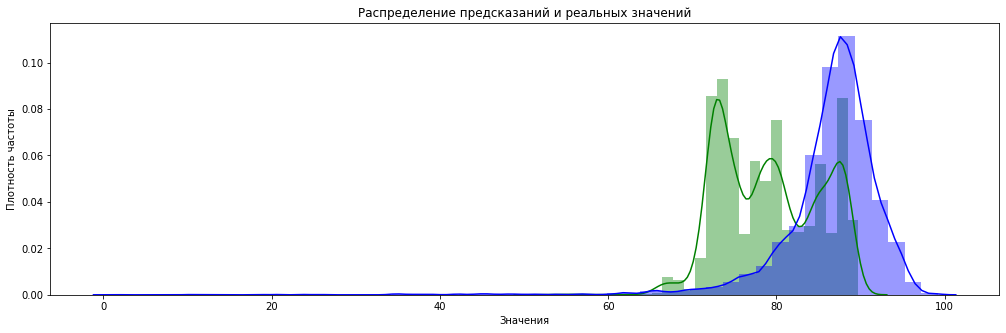

In [102]:
final_deviation_compare(rouger_predict, df_test_target['rougher.output.recovery'])

И для финального обогащения:

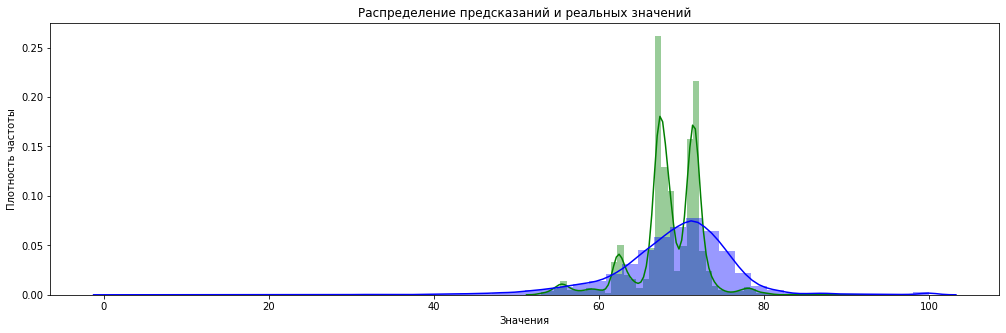

In [103]:
final_deviation_compare(final_predict, df_test_target['final.output.recovery'])

Из графиков видно, что модель хуже справляется на предсказаниях эффективности обогащения чернового концентрата, в тоже время предсказания эффективности обогащения финального концентрата значительно лучше.   
Признаков для обучения чернового концентрата меньше, чем для финального. Вероятно, в этом такое различие.  
симметричное среднее абсолютное процентное отклонение для чернового концентрата - 11.68 %  
симметричное среднее абсолютное процентное отклонение для финального концентрата - 8.48 %  
Разница в 3 %

Для проверки модели на адекватность сравним с моделью, которая всегда предсказывает ~~случайные~~ <b> средние</b> значение.  
Для того, чтобы получить ~~«случайные»~~ <b>средние</b> результаты, воспользуемся ~~DummyClassifier~~ `DummyRegressor`. ~~Полученные им результаты абсолютно случайные~~.  
Стратегию выставим ~~`strategy='uniform'`~~ `strategy='mean'`

In [104]:
#dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
dummy_model = DummyRegressor(strategy = 'mean')

Посчитаем итоговое sMAPE для такой модели:

In [105]:
test_predicts_and_total_sMAPE(dummy_model)

sMAPE для rougher.output.recovery: 6.00 %
sMAPE для final.output.recovery: 8.30 %
Итоговое sMAPE: 7.72 %


(array([83.9180434, 83.9180434, 83.9180434, ..., 83.9180434, 83.9180434,
        83.9180434]),
 array([67.70017959, 67.70017959, 67.70017959, ..., 67.70017959,
        67.70017959, 67.70017959]))

~~Разница между предсказаниями обученной модели random_forest_model_2 и абсолютно случайной ~ 32,42 %~~

Разница между предсказаниями обученной модели random_forest_model_2 и средней почти нет (1% не в пользу модели случайного леса), Причина в предсказания для чернового концентрата, среднее предсказание сильно ниже предсказаний модели случайного леса. Возможная причина в меньшем кол-ве признаков для обучения модели для чернового концентрата. Тем не менее общая ошибка приемлема.

### Выводы по главе 3:

> - Из всех моделей, модель Случайного леса, с получеными гиперпараметрами, показала лучший результат по метрике sMAPE.  
- Итоговое sMAPE: 8.73 %  
- модель хуже справляется на предсказаниях эффективности обогащения чернового концентрата, в тоже время предсказания эффективности обогащения финального концентрата значительно лучше.  
- Следствием чего является практически отстутсвия различия между лучшей моделью и моделью предсказывающей среднее. Тем не менее общая ошибка приемлема

## Общий вывод:

**- В процессе предобработки данных выявлены пропуски в данных, т.к. данные поступили "сырыми", возможно, это послужило причиной**  
**- В Анализе данных обнаружили большое количество анамальных значений 0, такие данные повредят машинному обучению поэтому были удалены. Природа возникновения таких данных, вероятно, связана с природой получения данных в техническом процессе**  
**- Из всех моделей, модель Случайного Леса random_forest_model_2, показала лучший результат по итоговой метрике sMAPE.**  
**- Ее результат лучше случайной, предсказывающей всегда абсолютно случайные значение, однако не лучше модели предсказывающий среднее**  
**- Модель подходит для предсказания коэффициент восстановления золота из золотосодержащей руды, ~~как для чернового концентрата, так и~~для финального концентрата. Для чернового концентрата необходимо большее количество признаков, для улучшения работы модели. Тем не менее общая ошибка приемлема**  
**- Таким образом модель может помочь оптимизировать производство, и заранее предсказывать, если предприятие будет с убыточными характеристиками. Тем не менее рекомендуется обновлять и дополнять признаки для улучшения модели.**

**- Решение за заказчиком**
